# Data Modeling

## Neural Network
- We'll use the model ```NeuralNetwork``` from `tensorflow`.
- **Advantages of this model**
    - **Feature Interactions**: The selected features include a mix of numerical and categorical variables (tomatometer_score, tomatometer_count, audience_count, runtime, genre, classification, original_language). Neural networks can effectively handle both types of features and capture interactions between them, which is crucial when dealing with diverse types of data.
    - **Representation Learning**: Neural networks have the ability to automatically learn hierarchical representations of the input data. This is advantageous when dealing with categorical variables like genre, classification, and original_language because the model can learn meaningful representations rather than relying on handcrafted feature engineering.

### Import libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import seaborn as sns

### Preprocessing

In [2]:
# Load your data
data = pd.read_csv('D:/KHTN/NMKHDL/hcmus_nmkhdl_project/data/processed/data.csv')
data.head()

,name,genre,tomatometer_score,tomatometer_count,audience_score,audience_count,classification,runtime,release_year,original_language
0,A Castle for Christmas,Holiday,0.74,23.0,0.40,100.0,Not Rated,98.0,2021,English
1,Pinocchio,Kids & family,1.00,61.0,0.73,250000.0,G,87.0,1940,English
2,The Informer,Mystery & thriller,0.64,58.0,0.60,250.0,R,113.0,2019,English
3,They Cloned Tyrone,Sci-fi,0.95,129.0,1.00,25.0,R,122.0,2023,English
4,1917,War,0.89,472.0,0.88,25000.0,R,119.0,2019,English


In [13]:
# Define numerical and categorical features
numerical_features = ['tomatometer_score', 'tomatometer_count', 'audience_count', 'runtime']
categorical_features = ['genre', 'classification', 'original_language']

# Select specific features
selected_features = ['tomatometer_score', 'tomatometer_count', 'audience_count', 'runtime', 'genre', 'classification', 'original_language']
#Handle missing values
data.dropna(subset=numerical_features+['audience_score'], inplace=True)

### Train, Validation, Test set splitting

- We'll perform splitting on the following ratio (70/20/10)

In [14]:
# Select features and target variable
X = data[selected_features]
y = data['audience_score']

# Split the data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

### Transformer

In [15]:
# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'))
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [16]:
# Fit the ColumnTransformer on the training data
preprocessor.fit(X_train)

C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['tomatometer_score', 'tomatometer_count',
                                  'audience_count', 'runtime']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['genre', 'classification',
                                  'original_language'])])

### Hyperparameter tuning
- We'll perform hyperparameter tuning on two hyperparameters: `learning_rate` and `batch_size`.
- We'll record the `mean_squared_error` of every combination of these parameters on the validation set.
- Finally, we'll plot the corresponding heatmap.

### Model

### Layers
- Input Layer:

    - Type: Dense
    - Number of Neurons: 64
    - Activation Function: ReLU
    - Input Dimension: preprocessor.transform(X_train).shape[1]
    - This layer is the first hidden layer with ReLU activation.

- Hidden Layer:

    - Type: Dense
    - Number of Neurons: 32
    - Activation Function: ReLU
    - This is the second hidden layer with ReLU activation.

- Output Layer:

    - Type: Dense
    - Number of Neurons: 1
    - Activation Function: Linear
    - This is the output layer with a linear activation function, suitable for regression tasks.

In [17]:
# Combine preprocessing with model training in a pipeline
modelNN = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Sequential([
        Dense(64, activation='relu', input_dim=preprocessor.transform(X_train).shape[1]),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ]))
])

### Optimizer
- Using Adam optimizer for Neural Network Model

In [18]:
# Hyperparameters
learning_rates = [0.001, 0.002, 0.003, 0.004, 0.005]
batch_size = [50, 75, 100, 125, 150]

# Compile the Keras model with specified learning rate
results = np.zeros((5, 5))
for rate, bat in product(learning_rates, batch_size):
    optimizer = Adam(learning_rate=rate)
    modelNN.named_steps['regressor'].compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model with a reduced number of epochs
    modelNN.named_steps['regressor'].fit(
        preprocessor.transform(X_train), y_train,
        epochs=50, batch_size=bat,verbose=0)

    # Testing on the validation set and record error
    y_val_pred = modelNN.predict(X_val)
    error = mean_squared_error(y_val, y_val_pred)
    results[learning_rates.index(rate)][batch_size.index(bat)] = error

4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 1ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Plotting the heatmap

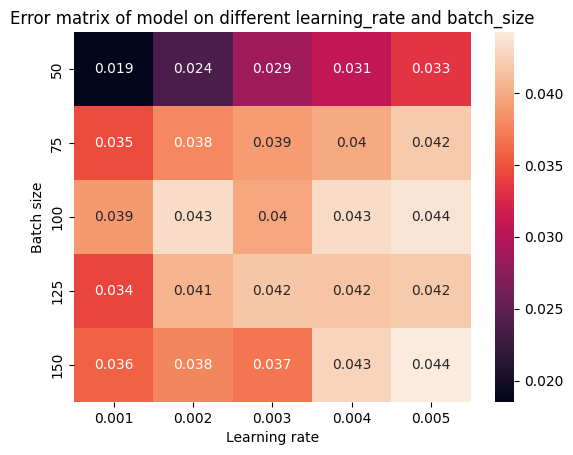

In [19]:
sns.heatmap(results, xticklabels=learning_rates, yticklabels=batch_size, annot=True)
plt.xlabel('Learning rate')
plt.ylabel('Batch size')
plt.title('Error matrix of model on different learning_rate and batch_size')
plt.show()

So, the best hyperparameters are `learning_rate = 0.001` and `batch_size = 50`.

### Training and Testing/Evaluation
- We perform fitting on training + validation set.
- Use squared error as the loss function.

Training

In [20]:
best_lr=0.001
best_bz=50

optimizer = Adam(learning_rate=best_lr)
modelNN.named_steps['regressor'].compile(optimizer=optimizer, loss='mean_squared_error')

history=modelNN.named_steps['regressor'].fit(
        preprocessor.transform(pd.concat([X_train,X_val])), pd.concat([y_train,y_val]),
        epochs=50, batch_size=best_bz,verbose=0)

C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Visualizing the running process

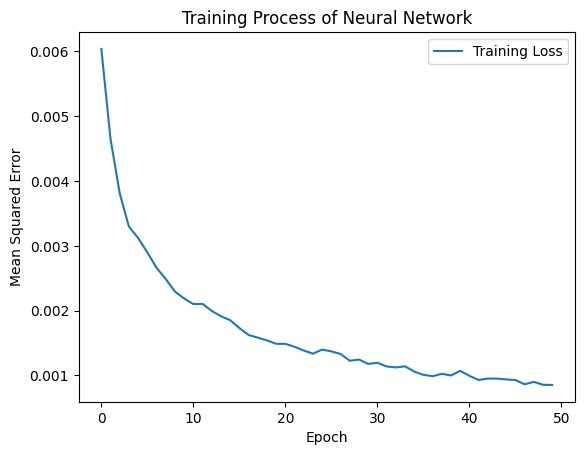

In [21]:
# Visualize training loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Process of Neural Network')
plt.legend()
plt.show()

Testing

In [22]:
y_test_pred = modelNN.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
print("MSE:", mse)

8/8 [==============================] - 0s 1ms/step
MSE: 0.048029930513709275


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
